In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro import poutine
import pyro.distributions as dist
import pyro.distributions.transforms as T
from torch.optim import Adam

import torch
from torch import tensor, sigmoid
from pyro.distributions import constraints
from torch.distributions.transforms import AffineTransform
import torch.distributions.transforms as TT
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import torch.nn.init as init
from donuts import compare, DonutsDataset
import os
import sys
from time import sleep
from functools import reduce
import inspect
from operator import itemgetter
from typing import *

pyro.set_rng_seed(1)
is_smoke_test = False
n_samples = 1000
batch_size = 64  # unused
dataset =  DonutsDataset(n_samples=n_samples, hole=None, noise=0.01, factor=0.3)
loader = DataLoader(dataset, batch_size=batch_size)  # unused

In [2]:
from functools import reduce
import sys
from functools import partial

def sumall(tens):
    reified = list(tens)  # FIXME: need the lookahead for initializer
    initializer = torch.zeros_like(reified[0])
    reducer = lambda l, memo: memo + l
    return reduce(reducer, reified, initializer)

def get_logprobs(tr, k):
    site = tr.nodes[k]
    assert site["type"] == "sample" and site["is_observed"], f'{k} is type {site["type"]} and is_observed: {site["is_observed"]}'
    return site["log_prob"]
    
def train(model, over_vars, dataset=dataset, n_epochs=500, lr=3e-3, n_samples=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x1, x2 = [dataset.data[x] for x in ['x1', 'x2']]
    dataset.data['x1_x2'] = torch.cat([x1, x2], dim=-1)  # for univariates
    losses = []
    with trange(n_epochs) as epoch_reporter:
        for step in epoch_reporter:
            optimizer.zero_grad()
            cond_model = pyro.condition(model.model, data=dataset.data)
            model_trace = poutine.trace(cond_model).get_trace()
            model_trace.compute_log_prob()
            loss = -sumall(map(partial(get_logprobs, model_trace), over_vars)).mean()
            loss.backward()
            optimizer.step()
            epoch_reporter.set_postfix_str('loss: {:.6f}'.format(loss.detach()))
            model.clear_cache()
    return losses

def visualize(model, dataset=dataset):
    with pyro.plate('samples', 1000):
        outs = model.model()
        x1_flow = outs[0]
        x2_flow = outs[1]
#         if len(outs) == 2:
#             x1_flow, x2_flow = outs
        y_flow = torch.ones_like(x1_flow)
#         elif len(outs) == 3:
#             x1_flow, x2_flow, y_flow = outs
    compare((x1_flow.detach(), x2_flow.detach(), y_flow.detach()), dataset)

class FlowBased(PyroModule):
    def __init__(self, verbose=True):
        super().__init__()
        self._register_buffers()
        self._build_flow()
 
    def build_flow(self):
        raise NotImplementedError()

    def _build_flow(self):
        self.flow_states = []
        before = set(dir(self))
        self.build_flow()
        after = set(dir(self))
        # FIXME: should also add an instance check
        self.flow_states = [getattr(self, new) for new in after - before]
        if len(self.flow_states) == 0:
            print("[WARNING] No flow states registered in self.flow_states after self._build_flow()")

    def register_buffers(self):
        return dict()

    def _register_buffers(self):
        pairs = self.register_buffers()
        for name, tensor in pairs.items():
            assert tensor.requires_grad is not True, f"{name} shouldn't be in autograd"
            self.register_buffer(name, tensor)

    def clear_cache(self):
        for flow in self.flow_states:
            try:
                flow.clear_cache()
            except:
                pass

def smoke_test(model):
    print(model.model())
    with pyro.plate('test', 13):
        out = model.model()
        print(out[0].shape)
    sleep(0.5)

(tensor(-0.0497, grad_fn=<SelectBackward>), tensor(-0.7749, grad_fn=<SelectBackward>))
torch.Size([13])


100%|██████████| 1000/1000 [00:04<00:00, 246.82it/s, loss: 1.126449]


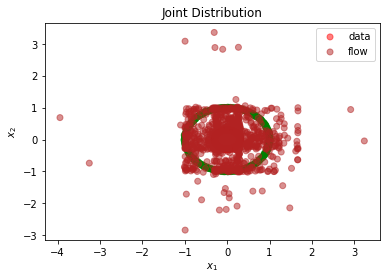

/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

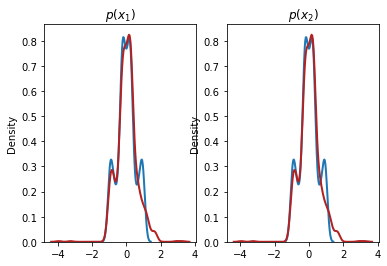

CPU times: user 43.4 s, sys: 754 ms, total: 44.1 s
Wall time: 6.47 s


In [3]:
%%time
class UnivariateModel(FlowBased):
    def __init__(self):
        super().__init__()
        # NOTE: Flows require a stable latent to target. Thus we don't put these on the computation graph.
        self.register_buffer('loc', torch.zeros([2], requires_grad=False))
        self.register_buffer('scale', torch.ones([2], requires_grad=False))

    def build_flow(self):
        self.spline_transform = T.Spline(2, count_bins=16)

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        flow_dist = dist.TransformedDistribution(dist_base, [self.spline_transform])
        xs = pyro.sample('x1_x2', flow_dist.to_event(1))
        # account for batching
        return (xs[:,0], xs[:,1]) if len(xs.shape) == 2 else (xs[0], xs[1])

model = UnivariateModel()
smoke_test(model)

losses = train(model, n_epochs=1 if is_smoke_test else 1000, n_samples=1000, over_vars=['x1_x2'])
visualize(model)

(tensor(-0.5649, grad_fn=<SelectBackward>), tensor(-0.5952, grad_fn=<SelectBackward>))
torch.Size([13])


100%|██████████| 1000/1000 [00:07<00:00, 136.80it/s, loss: -0.536185]


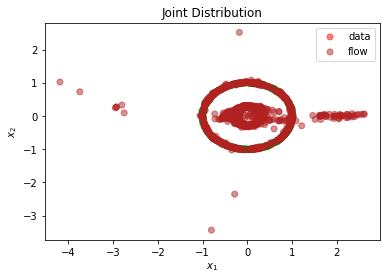

/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

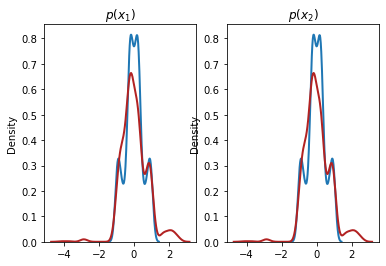

CPU times: user 1min 13s, sys: 1.27 s, total: 1min 15s
Wall time: 8.17 s


In [4]:
%%time

class MultivariateModel(FlowBased):
    def __init__(self):
        super().__init__()
        self.register_buffer('loc', torch.zeros([2], requires_grad=False))
        self.register_buffer('scale', torch.ones([2], requires_grad=False))

    def build_flow(self):
        self.spline_transform = T.spline_coupling(2, count_bins=16)

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        flow_dist = dist.TransformedDistribution(dist_base, [self.spline_transform])
        xs = pyro.sample('x1_x2', flow_dist)
        # account for batching
        return (xs[:,0], xs[:,1]) if len(xs.shape) == 2 else (xs[0], xs[1])

model = MultivariateModel()
smoke_test(model)

losses = train(model, n_epochs=1 if is_smoke_test else 1000, n_samples=1000, over_vars=['x1_x2'])
visualize(model)

(tensor([0.6125], grad_fn=<IndexPutBackward>), tensor([1.0471], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 5000/5000 [00:35<00:00, 142.62it/s, loss: -0.642030]


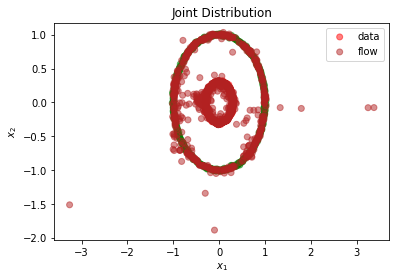

/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

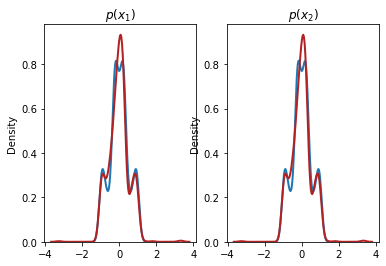

CPU times: user 5min 47s, sys: 5.98 s, total: 5min 53s
Wall time: 36 s


In [5]:
%%time
class ConditionalModel(FlowBased):
    def __init__(self):
        super().__init__()
        # NOTE: Flows require a stable latent to target. Thus we don't put these on the computation graph.
        self.register_buffer('loc', torch.zeros([1], requires_grad=False))
        self.register_buffer('scale', torch.ones([1], requires_grad=False))

    def build_flow(self):
        self.x1_transform = T.spline(1)
        self.x2_transform = T.conditional_spline(1, context_dim=1)   # placed in parameters

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        dist_x1 = dist.TransformedDistribution(dist_base, [self.x1_transform])
        dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [self.x2_transform])
        x1 = pyro.sample('x1', dist_x1.to_event(1))
        x2 = pyro.sample('x2', dist_x2_given_x1.condition(x1.detach()).to_event(1))
        return x1, x2

model = ConditionalModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2'], n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

(tensor([-0.4528], grad_fn=<IndexPutBackward>), tensor([-0.7863], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 5000/5000 [00:42<00:00, 116.80it/s, loss: 0.563091]


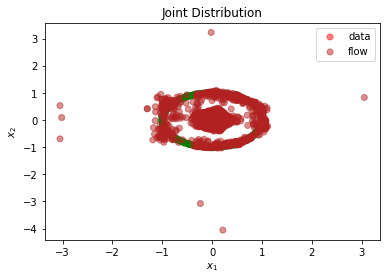

/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

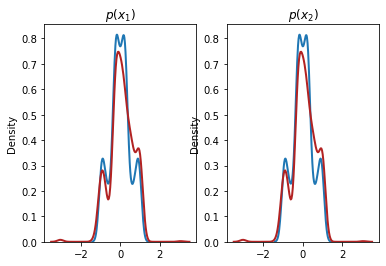

In [6]:
class NoiseModel(FlowBased):
    def __init__(self):
        super().__init__()

    def build_flow(self):
        self.register_buffer('noise_base_loc', torch.zeros([1], requires_grad=False))
        self.register_buffer('noise_base_scale', torch.ones([1], requires_grad=False))
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.x1_transform = T.conditional_spline(1, context_dim=1)
        self.x2_transform = T.conditional_spline(1, context_dim=2)   # placed in parameters

    def model(self):
        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale)
        dist_noise = dist.TransformedDistribution(noise_base_dist, [self.noise_flow_lognorm])

        dist_x1_given_noise = dist.ConditionalTransformedDistribution(dist_noise, [self.x1_transform])
        dist_x2_given_noise = dist.ConditionalTransformedDistribution(dist_noise, [self.x2_transform])

        noise = pyro.sample('noise', dist_noise.to_event(1))
        x1 = pyro.sample('x1', dist_x1_given_noise.condition(noise.detach()).to_event(1))
        ctx = torch.cat([noise.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', dist_x2_given_noise.condition(ctx).to_event(1))
        return x1, x2

model = NoiseModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2', 'noise'], n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

(tensor([-1.4650], grad_fn=<IndexPutBackward>), tensor([0.7994], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 10000/10000 [01:35<00:00, 104.78it/s, loss: 0.963781]


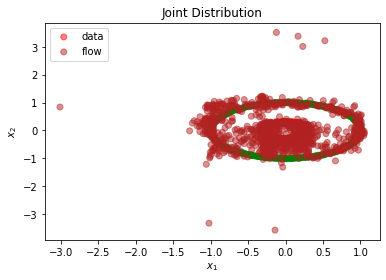

/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

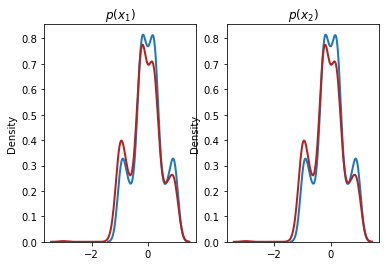

In [7]:
class ContinuousModel(FlowBased):
    def __init__(self):
        super().__init__()
        #self.label_logits = torch.nn.Parameter(torch.zeros([1, ]))

    def register_buffers(self):
        return dict(
            x1_base_loc=torch.zeros([1]),     x1_base_scale=torch.ones([1]),
            x2_base_loc=torch.zeros([1]),     x2_base_scale=torch.ones([1]),
            noise_base_loc=torch.zeros([1]),  noise_base_scale=torch.ones([1]),
            factor_base_loc=torch.zeros([1]), factor_base_scale=torch.ones([1]),
        )

    def build_flow(self):
        self.x1_flow_lognorm = AffineTransform(loc=self.x1_base_loc.item(), scale=self.x1_base_scale.item())
        self.x2_flow_lognorm = AffineTransform(loc=self.x2_base_loc.item(), scale=self.x2_base_scale.item())
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.factor_flow_lognorm = AffineTransform(loc=self.factor_base_loc.item(), scale=self.factor_base_scale.item())

        self.x1_transform = T.conditional_spline(1, context_dim=2, count_bins=16)
        self.x2_transform = T.conditional_spline(1, context_dim=3, count_bins=16)   # placed in parameters

    def model(self):
        x1_base_dist = dist.Normal(self.x1_base_loc, self.x1_base_scale)
        dist_x1 = dist.TransformedDistribution(x1_base_dist, [self.x1_flow_lognorm])

        x2_base_dist = dist.Normal(self.x2_base_loc, self.x2_base_scale)
        dist_x2 = dist.TransformedDistribution(x2_base_dist, [self.x2_flow_lognorm])

        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale)
        dist_noise = dist.TransformedDistribution(noise_base_dist, [self.noise_flow_lognorm])

        factor_base_dist = dist.Normal(self.factor_base_loc, self.factor_base_scale)
        dist_factor = dist.TransformedDistribution(factor_base_dist, [self.factor_flow_lognorm])

        cond_dist_x1 = dist.ConditionalTransformedDistribution(dist_x1, [self.x1_transform])
        cond_dist_x2 = dist.ConditionalTransformedDistribution(dist_x2, [self.x2_transform])

        noise = pyro.sample('noise', dist_noise.to_event(1))
        factor = pyro.sample('factor', dist_factor.to_event(1))
        ctx1 = torch.cat([noise.detach(), factor.detach()], dim=-1)
        x1 = pyro.sample('x1', cond_dist_x1.condition(ctx1).to_event(1))

        ctx2 = torch.cat([ctx1.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', cond_dist_x2.condition(ctx2).to_event(1))
        return x1, x2

model = ContinuousModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2', 'noise', 'factor'], n_epochs=(1 if is_smoke_test else 10000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

In [8]:

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method
from pyro import poutine
import pyro.distributions as dist
from pyro.distributions import Normal, Bernoulli, TransformedDistribution
from pyro.distributions.torch_transform import ComposeTransformModule
from pyro.distributions.conditional import ConditionalTransformModule, ConditionalTransformedDistribution
from pyro.infer.reparam.transform import TransformReparam
import pyro.distributions.transforms as T
from pyro.distributions.transforms import ComposeTransform, SigmoidTransform, AffineTransform
from pyro.distributions import constraints
from pyro.nn import DenseNN
from torch.distributions import Independent


In [9]:
from pyro.distributions.transforms import ComposeTransform, SigmoidTransform, AffineTransform
from pyro.distributions.torch_transform import ComposeTransformModule
from pyro.nn import DenseNN

# from deepscm.distributions.transforms.affine.py
class ConditionalAffineTransform(ConditionalTransformModule):
    def __init__(self, context_nn, event_dim=0, **kwargs):
        super().__init__(**kwargs)

        self.event_dim = event_dim
        self.context_nn = context_nn

    def condition(self, context):
        loc, log_scale = self.context_nn(context)
        scale = torch.exp(log_scale)

        ac = T.AffineTransform(loc, scale, event_dim=self.event_dim)
        return ac

In [10]:
class ContinuousSCMModel(FlowBased):
    def __init__(self):
        super().__init__()

    def register_buffers(self):
        return dict(
            x1_base_loc=torch.zeros([1]),     x1_base_scale=torch.ones([1]),
            x2_base_loc=torch.zeros([1]),     x2_base_scale=torch.ones([1]),
            noise_base_loc=torch.zeros([1]),  noise_base_scale=torch.ones([1]),
            factor_base_loc=torch.zeros([1]), factor_base_scale=torch.ones([1]),
            noise_flow_norm_loc=torch.zeros([1]), noise_flow_norm_scale=torch.ones([1]),
            factor_flow_norm_loc=torch.zeros([1]), factor_flow_norm_scale=torch.ones([1]),
        )

    def build_flow(self):
        self.x1_flow_lognorm = AffineTransform(loc=self.x1_base_loc.item(), scale=self.x1_base_scale.item())
        self.x2_flow_lognorm = AffineTransform(loc=self.x2_base_loc.item(), scale=self.x2_base_scale.item())
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.factor_flow_lognorm = AffineTransform(loc=self.factor_base_loc.item(), scale=self.factor_base_scale.item())

        self.x1_transform = T.conditional_spline(1, context_dim=2, count_bins=16)
        self.x2_transform = T.conditional_spline(1, context_dim=3, count_bins=16)   # placed in parameters

        # parametrizes the noise flow base distribution
        self.noise_flow_norm = AffineTransform(loc=self.noise_flow_norm_loc.item(), scale=self.noise_flow_norm_scale.item())

        # parametrizes the factor flow base distribution
        self.factor_flow_norm = AffineTransform(loc=self.factor_flow_norm_loc.item(), scale=self.factor_flow_norm_scale.item())

        # flow for modeling noise
        self.noise_spline, self.noise_sigmoid = T.Spline(1), SigmoidTransform()
        self.noise_flow_components = ComposeTransformModule([self.noise_spline])
        self.noise_flow_constraint_transforms = ComposeTransform([self.noise_flow_norm, self.noise_sigmoid])
        self.noise_flow_transforms = ComposeTransform([self.noise_flow_components, self.noise_flow_constraint_transforms])
        
        # flow for modeling factor variable, conditioned on the noise value
        factor_net = DenseNN(1, [1], param_dims=[1, 1], nonlinearity=nn.Identity())
        self.factor_flow_components = ConditionalAffineTransform(context_nn=factor_net, event_dim=0)
        self.factor_sigmoid = SigmoidTransform()
        self.factor_flow_constraint_transforms = ComposeTransform([self.factor_flow_norm, self.factor_sigmoid])
        self.factor_flow_transforms = [self.factor_flow_components, self.factor_flow_constraint_transforms]

    def pgm_model(self):
        # create noise distribution
        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale).to_event(1) # FIXME
        self.noise_dist = dist.TransformedDistribution(noise_base_dist, self.noise_flow_transforms)
        
        # sample noise value
        noise = pyro.sample('noise', self.noise_dist)
        noise_ = self.noise_flow_constraint_transforms.inv(noise) # transformed version of N_noise
        # pseudo call to noise_flow_transforms to register with pyro
        _ = self.noise_flow_components
        
        # create factor distribution
        factor_base_dist = dist.Normal(self.factor_base_loc, self.factor_base_scale).to_event(1)
        self.factor_dist = dist.ConditionalTransformedDistribution(base_dist=factor_base_dist, transforms=self.factor_flow_transforms).condition(noise_)
        
        # sample factor value
        factor = pyro.sample('factor', self.factor_dist)
        # psuedo call to factor_flow_components to register with pyro
        _ = self.factor_flow_components

        return noise, factor

    def model(self):
        noise, factor = self.pgm_model()

        x1_base_dist = dist.Normal(self.x1_base_loc, self.x1_base_scale)
        dist_x1 = dist.TransformedDistribution(x1_base_dist, [self.x1_flow_lognorm])

        x2_base_dist = dist.Normal(self.x2_base_loc, self.x2_base_scale)
        dist_x2 = dist.TransformedDistribution(x2_base_dist, [self.x2_flow_lognorm])

        cond_dist_x1 = dist.ConditionalTransformedDistribution(dist_x1, [self.x1_transform])
        cond_dist_x2 = dist.ConditionalTransformedDistribution(dist_x2, [self.x2_transform])

        ctx1 = torch.cat([noise.detach(), factor.detach()], dim=-1)
        x1 = pyro.sample('x1', cond_dist_x1.condition(ctx1).to_event(1))

        ctx2 = torch.cat([ctx1.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', cond_dist_x2.condition(ctx2).to_event(1))
        return x1, x2, noise, factor

    def infer_exogenous(self, **obs):
        cond_sample = pyro.condition(self.model, data=obs)
        cond_trace = poutine.trace(cond_sample).get_trace()

        output = {}
        for name, node in cond_trace.nodes.items():
            if 'fn' not in node.keys():
                continue

            fn = node['fn']
            if isinstance(fn, Independent):
                fn = fn.base_dist
            if isinstance(fn, TransformedDistribution):
                output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])
        return output
    
    def counterfactual(self, obs, condition=None):
        exogenous = self.infer_exogenous(**obs)
        counter = poutine.do(poutine.condition(self.scm, data=exogenous), data=condition)()
        return {k: v for k, v in zip(( 'x1', 'x2', 'noise', 'factor'), counter)}
    
    @pyro_method
    def scm(self, *args, **kwargs):
        def config(msg):
            if isinstance(msg['fn'], TransformedDistribution):
                return TransformReparam()
            else:
                return None

        return pyro.poutine.reparam(self.model, config=config)(*args, **kwargs)
    
    @pyro_method
    def sample_scm(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.scm()

        return (*samples,)

model = ContinuousSCMModel()
smoke_test(model)

is_smoke_test = False
losses = train(model, over_vars=['x1', 'x2', 'noise', 'factor'], n_epochs=(1 if is_smoke_test else 1000), n_samples=1000)

(tensor([-1.1765], grad_fn=<IndexPutBackward>), tensor([-0.6714], grad_fn=<IndexPutBackward>), tensor([0.8658], grad_fn=<ClampBackward>), tensor([0.0594], grad_fn=<ClampBackward>))
torch.Size([13, 1])


100%|██████████| 1000/1000 [00:14<00:00, 69.27it/s, loss: 0.589508]


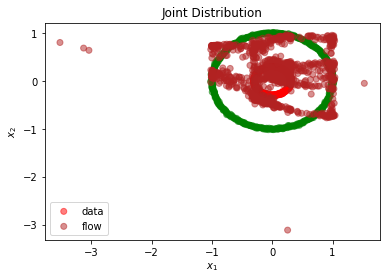

/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

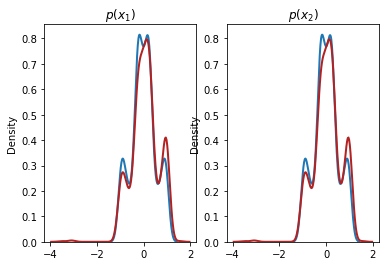

In [11]:
visualize(model)

In [12]:
with torch.no_grad():
    model_trace = poutine.trace(model.model).get_trace()
    sample = {k: model_trace.nodes[k]['value'] for k in  ['factor', 'noise', 'x1', 'x2']}
    print(sample)
    print(model.infer_exogenous(**sample))
    print(model.counterfactual(obs=sample, condition=dict(factor=torch.tensor([0.1]))))
    
    many = [model.counterfactual(obs=sample, condition=dict(factor=torch.tensor([0.1]))) for _ in range(1000)]

{'factor': tensor([0.3732]), 'noise': tensor([0.8435]), 'x1': tensor([0.0354]), 'x2': tensor([0.1969])}
{'noise_base': tensor([-0.7533]), 'factor_base': tensor([-0.2410]), 'x1_base': tensor([-0.0232]), 'x2_base': tensor([0.1152])}
{'x1': tensor([-0.7921]), 'x2': tensor([-0.1017]), 'noise': tensor([0.8435]), 'factor': tensor([0.1000])}


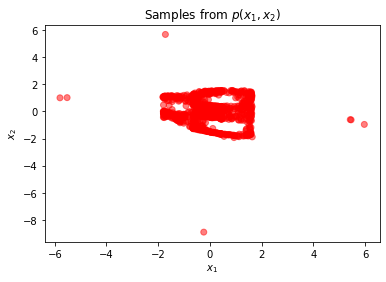

/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


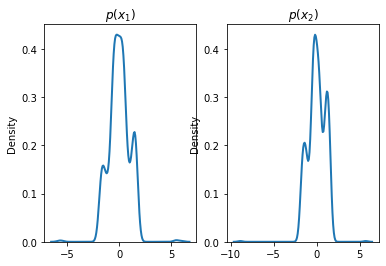

In [13]:
from donuts import plot
X = torch.stack(list(map(lambda x: torch.cat([x['x1'], x['x2']]), many)))
plot(X[:,0].view(-1,1), X[:,1].view(-1,1), torch.ones_like(X[:,1]).view(-1,1))
